In [23]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from scipy.optimize import curve_fit
from scipy.special import ellipk as K1
from scipy.special import ellipe as K2 #Complete elliptic integral of the first kind

In [24]:
#Read in data
project_directory = os.path.dirname(os.path.abspath("ising_plot.ipynb"))
data_directory = os.path.join(project_directory, "data_close")
rel_files = os.listdir(data_directory)
abs_files = [os.path.join(data_directory, rel_file) for rel_file in rel_files]
data_files = [file for file in abs_files if not file.find('EM')==-1]
corr_files = [file for file in abs_files if not file.find('SC')==-1]
datas= []
corrs= []
for file in data_files:
    data = pd.read_csv(file, sep=",", skiprows=[0,1,2])
    datas.append(data)
for file in corr_files: 
    corr = pd.read_csv(file, sep=",", skiprows=[0,1,2])
    corrs.append(corr)

In [25]:
T_c_analytic = 2/np.log(1 + np.sqrt(2))  # Analytic critical temperature for the 2D Ising model
ln_T_c_analytic = np.log(T_c_analytic)

def get_E_mean_analytic(T):
    """Calculate the mean energy for the 2D Ising model at temperature T."""
    assert (T >= 0).all(), "Temperature is negative"
    sinh_T = np.sinh(2/T)
    cosh_T = np.cosh(2/T)
    tanh_T = np.tanh(2/T)
    #kappa = 2*sinh_T/cosh_T**2
    kappa = 2*tanh_T/cosh_T #Numerically more stable?
    ellip_int = K1(kappa)
    return -2*tanh_T-(sinh_T**2-1)/(sinh_T*cosh_T)*(2/np.pi*ellip_int-1)

def get_M_abs_analytic(T,B=None): #Absolute value because of spontaneous symmetry breaking
    assert (T >= 0).all(), "Temperature is negative"
    if B is not None:
        assert (B == 0).all(), "Expression only valid for B = 0"
    M_abs_inner = 1-np.sinh(2/T)**-4
    M_abs = np.where(T>=T_c_analytic,0,np.sign(M_abs_inner)*np.abs(M_abs_inner)**(1/8)) #Note continuity at T = T_c_analytic
    return M_abs

def get_cV_analytic(T):
    assert (T >= 0).all(), "Temperature is negative"
    b = 2/T #Thermodynamic beta up to a multiplicative constant
    sinh_b = np.sinh(b)
    cosh_b = np.cosh(b)
    tanh_b = np.tanh(b)
    kappa_b = 2*tanh_b/cosh_b #Numerically more stable?
    K1_int = K1(kappa_b)
    K2_int = K2(kappa_b)
    K1_prime =  (K2_int/(1-kappa_b**2)-K1_int)/kappa_b 
    zero_term = sinh_b**-2
    first_term = -(sinh_b**-2+2*cosh_b**-2)*(2/np.pi)*K1_int
    second_term = 4/np.pi*(sinh_b**2-1)**2/(sinh_b*cosh_b**4)*K1_prime
    cV_analytic = -b**2/2 * (zero_term + first_term + second_term)
    return cV_analytic

def get_chi_analytic(T): #Need partial derivative of M with respect to B
    assert (T >= 0).all(), "Temperature is negative"
    return 0

In [26]:
#Models for fitting
def power_law_fit(T, k, T_c, crit_exp):
    t = (T-T_c)/T_c
    return k * ( t** crit_exp)

#Returns bounds as formatted for curve_fit
#[(L1,U1),(L2,U2),...(LN,UN)] to ([L1,L2,...,LN],[U1,U2,...,UN])
def to_tuple(bounds: list):
  lower = [b[0] for b in bounds]
  upper = [b[1] for b in bounds]
  return (lower,upper)

In [27]:
#Settings for the analysis
selected_trial = 1 #Particular trial to analyze (0-indexed)

#Extract data from pandas DataFrame
data_selected_trial = datas[selected_trial]
corr_selected_trial = corrs[selected_trial]
T, E_mean, E_std, M_mean, M_std= data_selected_trial.T.to_numpy()
corr_data = corr_selected_trial.T.to_numpy()
T_corr = corr_data[0]
assert (T==T_corr).all(), "The correlation CSV is not synced properly with the main CSV"
R_data = corr_data[1:]
R_mean, R_std = [R_data[i] for i in range(0,len(R_data),2)], [R_data[i] for i in range(1,len(R_data),2)]

cV = np.square(E_std)/np.square(T) #In units where k_B = 1
chi = np.square(M_std)/T #In units where k_B = 1
#cV_mean will need to come from combined best estimate: average of cV over CSVs (weighted by cV itself because this is the best estimate for the error of each cV?)
#cV_std will need to come from the standard error of standard deviation
#Same for chi_mean, chi_std

#General calculations
N = len(T)
T_min, T_max = T.min(), T.max()
T_analytic = np.linspace(T_min, T_max, 1000)

#Logarithmic scale calculations
ln_T = np.log(T)
ln_T_analytic = np.linspace(np.log(T_min), np.log(T_max), 1000)
def get_ln_std(X_mean, X_std, use_asymetric_error=True):
    if use_asymetric_error: #Asymmetric error handling
        ln_X_std_lower = np.abs(np.log(X_mean-X_std)) 
        ln_X_std_upper = np.abs(np.log(X_mean+X_std))
        ln_X_std = [ln_X_std_lower, ln_X_std_upper] 
    else:
        ln_X_std = X_std / X_mean  # Propagated error (necessarily symmetric)
    return ln_X_std

In [28]:
def T_fit(X_mean, X_std, expected_crit_exp = 1.0, from_above = True, print_summary = True):
    bounds = to_tuple([(-np.inf, np.inf), (0, np.inf), (-np.inf, np.inf)]) #Bounds for k, T_c, crit_exp    
    param_ests = [1, T_c_analytic, expected_crit_exp] #Initial values for k, T_C, crit_exp
    if from_above: #Approach critical temperature from above
        T_filt = T[T >= T_c_analytic]
        X_mean_filt = X_mean[T >= T_c_analytic]
        X_std_filt = X_std[T >= T_c_analytic]                
    else: #Approach critical temperature from below
        T_filt = T[T <= T_c_analytic]
        X_mean_filt = X_mean[T <= T_c_analytic]
        X_std_filt = X_std[T <= T_c_analytic] 

    popt, pcov = curve_fit(power_law_fit, T_filt, X_mean_filt, sigma=X_std_filt, p0=param_ests,bounds=bounds)

    X_mean_filt_fit = power_law_fit(T_filt,*popt)      
    X_mean_filt_res = X_mean_filt - X_mean_filt_fit
    X_mean_filt_norm_res = X_mean_filt_res/X_std_filt
    N_filt = len(X_mean_filt_norm_res) #Number of points used for the fit
    num_constraints = len(popt)
    degrees_of_freedom = N_filt - num_constraints  # Degrees of freedom for the fit
    chi_squared = np.sum(np.square(X_mean_filt_norm_res))
    reduced_chi_squared = chi_squared / degrees_of_freedom    

    if print_summary:
        print(f"Reduced chi squared (fit): {reduced_chi_squared}")  

    return popt, pcov, X_mean_filt_norm_res   

In [29]:
def create_T_plot(X_mean, X_std=None, X_symbol=r"?", X_name=r"???", get_X_analytic=None, log_plot = True, perform_fit=False, expected_crit_exp = 1.0, from_above=True):   
    #Error handling
    if X_std is None: #No error is given
        X_std = np.zeros_like(X_mean)
        with_errorbar = False
    else: #Check if error is identically 0
        with_errorbar = not (X_std == np.zeros_like(X_std)).all() 
    if not with_errorbar:
        print("*Proceeding assuming no error (unphysical)")

    if perform_fit: #Work in progress: need to be careful with signs          
        popt, pcov, X_mean_fit_norm_res=  T_fit(X_mean, X_std, expected_crit_exp=expected_crit_exp, from_above=from_above)          
             
    if get_X_analytic is not None: #If present, evaluate the analytic model for plotting if present
        X_mean_analytic = get_X_analytic(T_analytic) #T_analytic is of high spatial frequency to produce a smooth curve 
    else:
        X_mean_analytic = None

    if log_plot: #Calculations specific and plotting labels specific to using log plot
        ln_X_mean = np.log(X_mean)
        ln_X_std = get_ln_std(X_mean, X_std)

        if get_X_analytic is not None:       
            ln_X_mean_analytic = np.log(X_mean_analytic)
        else:
            ln_X_mean_analytic = None
        using = [ln_T,ln_T_analytic,ln_T_c_analytic, ln_X_mean, ln_X_std, ln_X_mean_analytic]
        T_label = '$ln(k_BT / J)$'
        X_label = f'$ln({X_symbol})$'
    else: #Calculations specific and plotting labels specific to non log plots     
        using = [T,T_analytic,T_c_analytic,X_mean, X_std, X_mean_analytic] #No analytic curve for non-power-law fits
        T_label = '$k_BT / J$'
        X_label = f'${X_symbol}$'
    
    if get_X_analytic is not None: #Calculations and plotting specific to having an analytic model
        #Residual calculations
        X_mean_res_analytic = X_mean - get_X_analytic(T)
        X_std_res_analytic = X_std
        X_mean_norm_res_analytic = X_mean_res_analytic / X_std
        X_std_norm_res_analytic = 1 #Always 1 since X_std_norm_res_analytic = X_std_res_analytic / X_std = 1

        #Goodness of fit to analytic model
        degrees_of_freedom_analytic = N #Relies on global variable in cell above
        chi_squared_analytic= np.sum(np.square(X_mean_norm_res_analytic)) 
        reduced_chi_squared_analytic = chi_squared_analytic / degrees_of_freedom_analytic     
        print(f"Reduced chi squared (analytic): {reduced_chi_squared_analytic}")

        #Plotting specific to having an analytic model
        fig, axs = plt.subplots(2,1, constrained_layout=True, sharex=True, height_ratios=[2, 1])
        ax, res_ax = axs[0], axs[1]                
        res_ax.errorbar(using[0], X_mean_norm_res_analytic, yerr=X_std_norm_res_analytic, fmt='o', color='blue', label='Residuals (analytic)')
        res_ax.axvline(x=using[2], color='red', linestyle='--', label='$T_c$ (analytic)')      
        ax.plot(using[1], using[5], color='orange', label='Analytic')               
        res_ax.set_xlabel(T_label)
        res_ax.set_ylabel('Normalized Residual')
        res_ax.axhline(0, color='orange', linestyle='--')      
    else: #Plotting specific to not having residuals
        fig, ax = plt.subplots(1,1, constrained_layout=True)
        ax.set_xlabel(T_label)
    #Plotting common to all variants    
    if with_errorbar:
        ax.errorbar(using[0], using[3], yerr=using[4], fmt='o', color='blue', label='Simulated')
    else:        
        ax.errorbar(using[0], using[3], fmt='o', yerr=None, color='blue', label='Simulated')
    ax.set_ylabel(X_label)
    ax.axvline(x=using[2], color='red', linestyle='--', label='$T_c$ (analytic)')        
    ax.legend()
    ax.set_title(f'{X_name} vs Temperature')
    plt.show()

Reduced chi squared (analytic): 0.0769275778558527


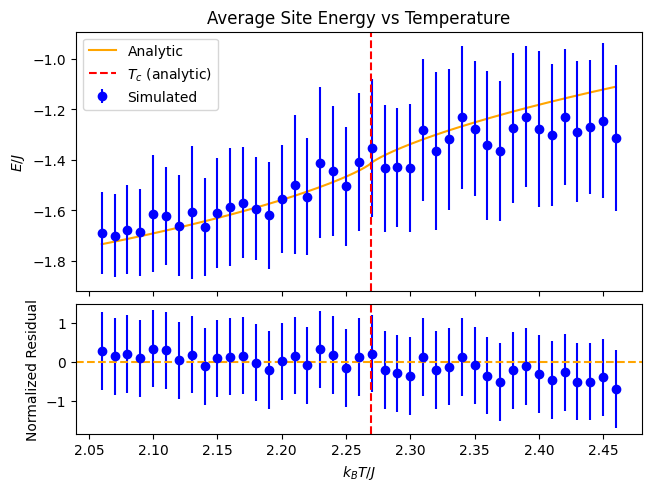

In [30]:
create_T_plot(E_mean, E_std, 'E/J', 'Average Site Energy', log_plot = False, get_X_analytic=get_E_mean_analytic)

Reduced chi squared (analytic): 1.2083601675841393


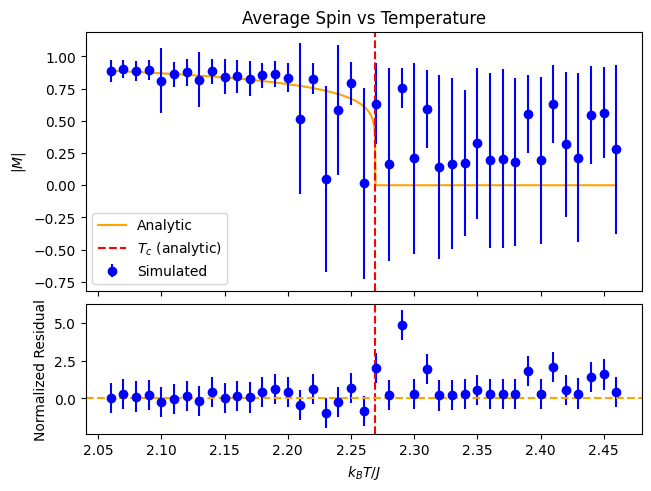

In [31]:
create_T_plot(np.abs(M_mean), M_std, '|M|', 'Average Spin', log_plot=False, expected_crit_exp=1/8, get_X_analytic=get_M_abs_analytic, perform_fit=False)

*Proceeding assuming no error (unphysical)
Reduced chi squared (analytic): inf


C:\Users\17757\AppData\Local\Temp\ipykernel_3048\3412892419.py:39: RuntimeWarning: divide by zero encountered in divide
  X_mean_norm_res_analytic = X_mean_res_analytic / X_std


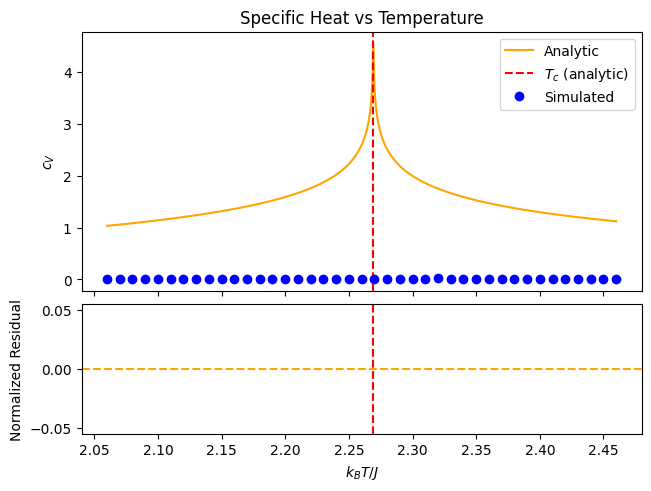

In [32]:
create_T_plot(cV, X_symbol='c_V', X_name='Specific Heat', log_plot = False, expected_crit_exp=0.0, get_X_analytic=get_cV_analytic) #zeros_like forces std to default which is then propagated for ln

In [33]:
#Autocorrelation Analysis
d_max = len(R_mean)
d = range(1,d_max+1)

In [34]:
#All files in directory
cVs = []
chis = []
for (data,corr) in (datas,corrs):
    T, E_mean, E_std, M_mean, M_std= data.T.to_numpy()
    corr_data = corr.T.to_numpy()
    T_corr = corr_data[0]
    assert (T==T_corr).all(), "The correlation CSV is not synced properly with the main CSV"
    R_data = corr_data[1:]
    R_mean, R_std = [R_data[i] for i in range(0,len(R_data),2)], [R_data[i] for i in range(1,len(R_data),2)]
    cV = np.square(E_std)/np.square(T) #In units where k_B = 1
    chi = np.square(M_std)/T #In units where k_B = 1
    cVs.append(cV)
    chis.append(chi)
cV_mean = np.mean(cVs, axis=0)
cV_std = np.std(cVs, axis=0)/np.sqrt(len(cVs)) #Standard error of the mean
chi_mean = np.mean(chis, axis=0)
chi_std = np.std(chis, axis=0)/np.sqrt(len(chis)) #Standard error of the mean

In [35]:
print(f"cV_mean: {cV_mean}")

cV_mean: [0.00321785 0.0032277  0.00524316 0.00405148 0.00447175 0.00447083
 0.00483074 0.00606134 0.00441204 0.00749158 0.00783938 0.00614446
 0.00534862 0.0053575  0.00545437 0.00592579 0.00603713 0.00646418
 0.00639012 0.00613024 0.00592013 0.00706846 0.00494758 0.00714029
 0.00680086 0.00818119 0.00656919 0.00773072 0.00470511 0.00731005
 0.00558879 0.00653496 0.00638459 0.00613492 0.0058832  0.00589726
 0.0059042  0.0076216  0.00662693 0.00593446 0.00561834]


Reduced chi squared (analytic): 155027.0172618874


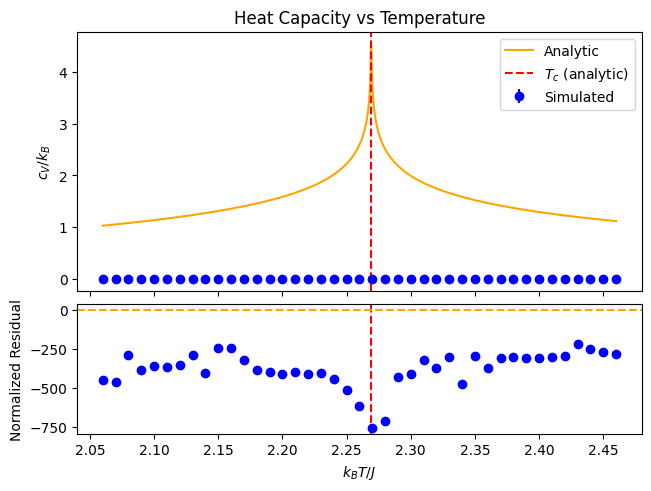

In [36]:
create_T_plot(cV_mean, cV_std, X_symbol=r'c_{V}/k_{B}', X_name='Heat Capacity', log_plot = False, expected_crit_exp=0.0, get_X_analytic=get_cV_analytic) #zeros_like forces std to default which is then propagated for ln

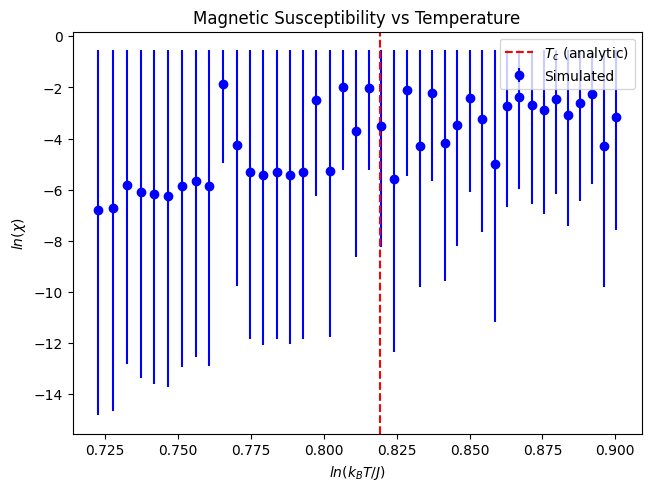

In [37]:
create_T_plot(chi_mean, chi_std, X_symbol= r'\chi', X_name='Magnetic Susceptibility', log_plot = True, expected_crit_exp=-7/4) #zeros_like forces std to default which is then propagated for ln